# Привет! Тут мы анализируем русскоязычные твиты :)

#### Датасет:
https://drive.google.com/drive/folders/0BxlA8wH3PTUfV1F1UTBwVTJPd3c    
#### Необходимые библиотеки
numpy, pandas, scikit-learn, gensim, tensorflow-gpu, keras    
#### Задания:
1. Успешно запустить имеющийся ноутбук
2. Запустить этот же ноутбук на данных ___ttk___
3. Реализовать свёрточную нейронную сеть для анализа твитов:
    - По аналогии с этой статьёй https://www.aclweb.org/anthology/D14-1181.
    - Провести нормализацию текстов (нижний регистр, чистка от пунктуации, приведение к нормальной форме с помощью pymorphy)
    - Использовать эмбеддинги FastText, как в прошлом домашнем задании: http://vectors.nlpl.eu/repository/11/181.zip
4. ***Сдавать это не понадобится, но вам потребуется для задачи DEV:
    - Обернуть ваш код в predictor.py 
    - Сохранить получившиися модели для банков и для телекомов: https://machinelearningmastery.com/save-load-keras-deep-learning-models/

#### _Подсказки_:    
- На вход нейросети будут поступать настаканные друг на друга эмбеддинги поочерёдно каждого слова в тексте.
- Реализацию архитектуры статьи делайте по аналогии с примерами обработки картинок с помощью Sequential, Conv2D, MaxPool, Dense, Dropout из keras.
- Результирующий X для keras будет 4D матрицей (кол-во сэмплов \* максимальная длина текста \* длину вектора эмбеддинга \* 1)    
- padding входных матриц (твиты - переменного размера, а нужно фиксированного, поэтому нужно матрицы добивать нулями или обрезать)    
- Чтобы адаптировать примеры с картинками к примерам с текстами, нужно аккуратно поменять размер рецептивного поля у Conv2D    
- Для keras нужно передавать метки класса в sparse-формате (П: не y=\[0,1,2\], a y=\[\[1,0,0\], \[0,1,0\], \[0,0,1\]\])
- Для улучшения результата можно вектора слов умножать на их Tf-Idf score, можно нормализовать весь X, добавлять Dropout в модель

Если будут вопросы - обращайтесь :)

## I. Импортим нужные библиотеки

In [1]:
import xmltodict
import re

import pandas as pd
import numpy as np
import tensorflow as tf
import pymorphy2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.layers import Softmax, Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## II. Определяем функции с парсингом входных данных

In [2]:
companies = {}
def get_sample_text(sample):
    assert sample['column'][3]['@name'] == 'text'
    return sample['column'][3]['#text']


def get_sample_answers_bank(sample):
    answers = {}
    for i in range(4, 12):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_answers_tkk(sample):
    answers = {}
    for i in range(4, 11):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_id(sample):
    assert sample['column'][0]['@name'] == 'id'
    return int(sample['column'][0]['#text'])


def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_bank(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

## III. Обрабатываем наши данные

In [49]:
train_filename = "../data/SentiRuEval_2016/bank_train_2016.xml"
test_filename = "../data/SentiRuEval_2016/banks_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)

## IV. Заменяем все ссылки и юзернеймы на url и user соответственно

In [50]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)

In [51]:
train.head()

text  answer     company  \
0                 url Взять кредит тюмень альфа банк       0    alfabank   
1                Мнение о кредитной карте втб 24 url       0         vtb   
2  «Райффайзенбанк»: Снижение ключевой ставки ЦБ ...       0  raiffeisen   
3  Современное состояние кредитного поведения в р...       0    sberbank   
4         user user Главное чтоб банки СБЕР и ВТБ!!!       1    sberbank   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

In [52]:
train['answer'].value_counts()

 0    7158
-1    2807
 1     760
Name: answer, dtype: int64

In [53]:
test.head()

text  answer company  \
0           #Автокредит в россельхозбанк в череповце       0    rshb   
1  RT user url #Кредитный калькулятор россельхозб...       0    rshb   
2              #Автокредит в россельхозбанк 2012 url       0    rshb   
3        RT user #Кредитные карты россельхозбанк url       0    rshb   
4      RT user #Кредиты в россельхозбанке ижевск url       0    rshb   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

## V. Преобразование нашей обучающей выборки по tf-idf

In [54]:
vectorizer = TfidfVectorizer()

In [55]:
X_train = vectorizer.fit_transform(train['text'])

In [56]:
X_train.shape

(10725, 11703)

## VI. Преобразование нашей тестовой выборки

In [57]:
X_test = vectorizer.transform(test['text'])

In [58]:
X_test.shape

(3418, 11703)

## VII. Обучение логистической регрессии

In [59]:
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', class_weight='balanced', max_iter=1000)

In [60]:
lr.fit(X_train, train['answer'])

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [61]:
y_pred = lr.predict(X_test)

## VIII. Смотрим на результаты
Считается F1 мера с микро и макро усреднением по негативному и положительному классу как в соревновании

In [62]:
f1_score(test['answer'], y_pred, average='micro', labels=[-1,1])

0.49823460180462925

In [63]:
f1_score(test['answer'], y_pred, average='macro', labels=[-1,1])

0.4698891720341647

## HW PART
1. Успешно запустить имеющийся ноутбук
2. Запустить этот же ноутбук на данных ___ttk___
3. Реализовать свёрточную нейронную сеть для анализа твитов:
    - По аналогии с этой статьёй https://www.aclweb.org/anthology/D14-1181.
    - Провести нормализацию текстов (нижний регистр, чистка от пунктуации, приведение к нормальной форме с помощью pymorphy)
    - Использовать эмбеддинги FastText, как в прошлом домашнем задании: http://vectors.nlpl.eu/repository/11/181.zip
4. ***Сдавать это не понадобится, но вам потребуется для задачи DEV:
    - Обернуть ваш код в predictor.py 
    - Сохранить получившиися модели для банков и для телекомов: https://machinelearningmastery.com/save-load-keras-deep-learning-models/

#### _Подсказки_:    
- На вход нейросети будут поступать настаканные друг на друга эмбеддинги поочерёдно каждого слова в тексте.
- Реализацию архитектуры статьи делайте по аналогии с примерами обработки картинок с помощью Sequential, Conv2D, MaxPool, Dense, Dropout из keras.
- Результирующий X для keras будет 4D матрицей (кол-во сэмплов \* максимальная длина текста \* длину вектора эмбеддинга \* 1)    
- padding входных матриц (твиты - переменного размера, а нужно фиксированного, поэтому нужно матрицы добивать нулями или обрезать)    
- Чтобы адаптировать примеры с картинками к примерам с текстами, нужно аккуратно поменять размер рецептивного поля у Conv2D    
- Для keras нужно передавать метки класса в sparse-формате (П: не y=\[0,1,2\], a y=\[\[1,0,0\], \[0,1,0\], \[0,0,1\]\])
- Для улучшения результата можно вектора слов умножать на их Tf-Idf score, можно нормализовать весь X, добавлять Dropout в модель

# Подготовка данных

In [132]:
def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_tkk(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

train_filename = "../data/SentiRuEval_2016/tkk_train_2016.xml"
test_filename = "../data/SentiRuEval_2016/tkk_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)
train.head()

text  answer  company  \
0  @mkomov Максим, Вашем письмо мы получили. Наши...       0  beeline   
1     «Мегафон» стал владельцем 50% акций «Евросети»       0  megafon   
2  RT @fuckkiev: “@EvaKobb: МТС Россия прислала ж...      -1      mts   
3  ВИДЕО: http://t.co/PSMLAhR4fI Реклама со смехо...       1      mts   
4  @parfenov1960 потому что МТС достало, а пчел н...      -1      mts   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

In [133]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)

print(train['answer'].value_counts())
train.head()

 0    5213
-1    2611
 1    1385
Name: answer, dtype: int64


text  answer  company  \
0  user Максим, Вашем письмо мы получили. Наши со...       0  beeline   
1     «Мегафон» стал владельцем 50% акций «Евросети»       0  megafon   
2  RT user “user МТС Россия прислала жителям Херс...      -1      mts   
3         ВИДЕО: url Реклама со смехом МТС - Супер 0       1      mts   
4  user потому что МТС достало, а пчел ненавижу с...      -1      mts   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

In [134]:
preprocess = lambda x: np.asarray(re.subn('[^\w\s%]', ' ', x.lower())[0].split())
train['text'] = train['text'].apply(preprocess)
test['text'] = test['text'].apply(preprocess)

In [135]:
train['len'] = train.text.apply(lambda x: len(x))
test['len'] = test.text.apply(lambda x: len(x))
MAX_LEN = max(train.len.max(), test.len.max())
print(MAX_LEN)
train.head()

31


text  answer  company  \
0  [user, максим, вашем, письмо, мы, получили, на...       0  beeline   
1  [мегафон, стал, владельцем, 50%, акций, евросети]       0  megafon   
2  [rt, user, user, мтс, россия, прислала, жителя...      -1      mts   
3   [видео, url, реклама, со, смехом, мтс, супер, 0]       1      mts   
4  [user, потому, что, мтс, достало, а, пчел, нен...      -1      mts   

   sample_id  len  
0          1   19  
1          2    6  
2          3   15  
3          4    8  
4          5   14

# Нормализация и перевод в эмбеддинги

In [136]:
path = '../models/ft/model.model'
ft = KeyedVectors.load(path)
morph = pymorphy2.MorphAnalyzer()

In [137]:
get_embed = lambda x: ft.get_vector(x[0])
get_prepared_data = lambda x: np.asarray(list(map(get_embed, map(morph.normal_forms, x))))
X_train = train.text.apply(get_prepared_data).values
X_test = test.text.apply(get_prepared_data).values

In [138]:
add_padding = lambda x: np.concatenate((x, np.zeros((MAX_LEN - x.shape[0], x.shape[1]))), axis=0)
X_train = np.asarray(list(map(add_padding, X_train)))
X_test = np.asarray(list(map(add_padding, X_test)))

In [139]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train.shape, X_test.shape

((9209, 31, 300, 1), (2460, 31, 300, 1))

In [140]:
y_train = np.zeros((X_train.shape[0], 3))
y_test = np.zeros((X_test.shape[0], 3))
y_train[:,0][train.answer == -1] = 1
y_train[:,1][train.answer == 0] = 1
y_train[:,2][train.answer == 1] = 1
y_test[:,0][test.answer == -1] = 1
y_test[:,1][test.answer == 0] = 1
y_test[:,2][test.answer == 1] = 1
y_train[:5], y_test[:5] 

(array([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]]))

In [141]:
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.1, random_state=17345)
ytrain.sum(axis=0)/ytrain.shape[0], yval.sum(axis=0)/yval.shape[0]

(array([0.28390444, 0.56563707, 0.15045849]),
 array([0.28013029, 0.57003257, 0.14983713]))

# Модель

In [144]:
input_shape = (31, 300, 1)
num_classes = 3
model = keras.Sequential([
            Conv2D(15, kernel_size=(3, 300), strides=(1, 1),
                activation='relu', input_shape=input_shape),
            Dropout(0.5),
            Conv2D(30, kernel_size=(2, 1), strides=(1, 1),
                activation='relu', input_shape=input_shape),
            #MaxPooling2D(pool_size=(2,1)),
            Flatten(),
            Dense(1000, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

es = EarlyStopping(min_delta=0.001, patience=6, monitor='val_loss')
mcheck = ModelCheckpoint('../models/tkk/', monitor='val_loss', save_best_only=True, verbose=1)
model.compile(optimizer=keras.optimizers.Nadam(), loss='categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 29, 1, 15)         13515     
_________________________________________________________________
dropout_48 (Dropout)         (None, 29, 1, 15)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 1, 30)         930       
_________________________________________________________________
flatten_25 (Flatten)         (None, 840)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 1000)              841000    
_________________________________________________________________
dense_51 (Dense)             (None, 3)                 3003      
Total params: 858,448
Trainable params: 858,448
Non-trainable params: 0
_______________________________________________

In [145]:
history = model.fit(Xtrain, ytrain, batch_size=50, epochs=250, validation_data=(Xval,yval), callbacks=[es, mcheck])

Epoch 1/250
163/166 [============================>.] - ETA: 0s - loss: 0.8368 - accuracy: 0.6371
Epoch 00001: val_loss improved from inf to 0.72282, saving model to ../models/tkk/
INFO:tensorflow:Assets written to: ../models/tkk/assets
166/166 [==============================] - 1s 9ms/step - loss: 0.8361 - accuracy: 0.6386 - val_loss: 0.7228 - val_accuracy: 0.6895
Epoch 2/250
162/166 [============================>.] - ETA: 0s - loss: 0.7161 - accuracy: 0.6993
Epoch 00002: val_loss improved from 0.72282 to 0.66728, saving model to ../models/tkk/
INFO:tensorflow:Assets written to: ../models/tkk/assets
166/166 [==============================] - 1s 7ms/step - loss: 0.7159 - accuracy: 0.6997 - val_loss: 0.6673 - val_accuracy: 0.7177
Epoch 3/250
163/166 [============================>.] - ETA: 0s - loss: 0.6593 - accuracy: 0.7193
Epoch 00003: val_loss improved from 0.66728 to 0.61438, saving model to ../models/tkk/
INFO:tensorflow:Assets written to: ../models/tkk/assets
166/166 [=============

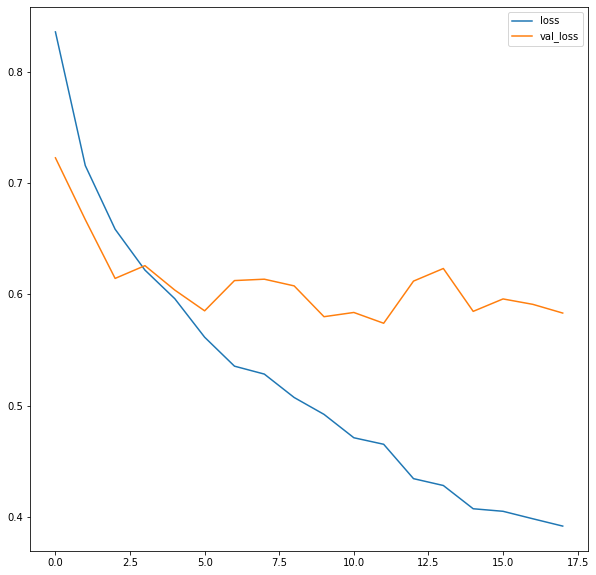

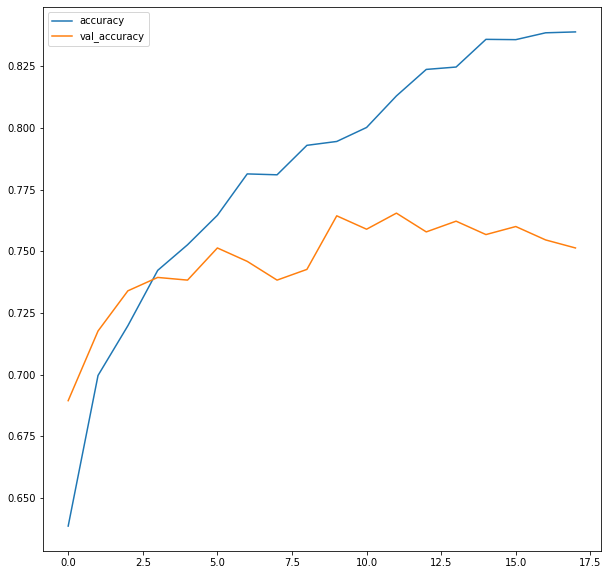

In [146]:
history_data = history.history
plt.figure(figsize=(10, 10))
plt.plot(history_data['loss'], label='loss')
plt.plot(history_data['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.figure(figsize=(10, 10))
plt.plot(history_data['accuracy'], label='accuracy')
plt.plot(history_data['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [147]:
best_model = keras.models.load_model('../models/tkk/')
ypred = best_model.predict_classes(X_test)
ypred -= 1
print('micro f1 = ', f1_score(test['answer'], ypred, average='micro', labels=[-1,1]))
print('macro f1 = ', f1_score(test['answer'], ypred, average='macro', labels=[-1,1]))

micro f1 =  0.6444036697247706
macro f1 =  0.513215539563435


# Тоже самое, но теперь на банках и используя мои обертки

In [125]:
from preprocessing import preprocess, MAX_LEN_bank
import predictor
import importlib
from sklearn.utils.class_weight import compute_class_weight
importlib.reload(predictor)
from predictor import Predictor, Model

In [126]:
def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_bank(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

train_filename = "../data/SentiRuEval_2016/bank_train_2016.xml"
test_filename = "../data/SentiRuEval_2016/banks_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)
train.head()

text  answer     company  \
0  http://t.co/YEVHuvVGA1 Взять кредит тюмень аль...       0    alfabank   
1  Мнение о кредитной карте втб 24 http://t.co/SB...       0         vtb   
2  «Райффайзенбанк»: Снижение ключевой ставки ЦБ ...       0  raiffeisen   
3  Современное состояние кредитного поведения в р...       0    sberbank   
4  @sawik_shuster @YevhenS Главное чтоб банки СБЕ...       1    sberbank   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

In [110]:
X_train = preprocess(train.text, MAX_LEN_bank)
X_test = preprocess(test.text, MAX_LEN_bank)
y_train = np.zeros((X_train.shape[0], 3))
y_test = np.zeros((X_test.shape[0], 3))
y_train[:,0][train.answer == -1] = 1
y_train[:,1][train.answer == 0] = 1
y_train[:,2][train.answer == 1] = 1
y_test[:,0][test.answer == -1] = 1
y_test[:,1][test.answer == 0] = 1
y_test[:,2][test.answer == 1] = 1

In [111]:
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=17345)
#weights = compute_class_weight('balanced', train['answer'].unique(), y_train_part.argmax(axis=1)-1)
#print(weights)
y_train_part.sum(axis=0)/y_train_part.shape[0], y_val.sum(axis=0)/y_val.shape[0], y_train.shape, y_test.shape

(array([0.26305429, 0.6665976 , 0.07034811]),
 array([0.24976701, 0.67474371, 0.07548928]),
 (10725, 3),
 (3418, 3))

In [127]:
input_shape = (30, 300, 1)
path_best_model = '../models/bank/'
model = Model(input_shape, 3, path_best_model, lr=0.0009)
history = model.fit(X_train_part, y_train_part, validation_data=(X_val, y_val))

Epoch 1/50
194/194 [==============================] - ETA: 0s - loss: 0.5156 - accuracy: 0.7965
Epoch 00001: val_loss improved from inf to 0.43150, saving model to ../models/bank/
INFO:tensorflow:Assets written to: ../models/bank/assets
194/194 [==============================] - 2s 9ms/step - loss: 0.5156 - accuracy: 0.7965 - val_loss: 0.4315 - val_accuracy: 0.8285
Epoch 2/50
189/194 [============================>.] - ETA: 0s - loss: 0.3770 - accuracy: 0.8504
Epoch 00002: val_loss improved from 0.43150 to 0.37555, saving model to ../models/bank/
INFO:tensorflow:Assets written to: ../models/bank/assets
194/194 [==============================] - 2s 8ms/step - loss: 0.3764 - accuracy: 0.8505 - val_loss: 0.3756 - val_accuracy: 0.8425
Epoch 3/50
193/194 [============================>.] - ETA: 0s - loss: 0.3424 - accuracy: 0.8636
Epoch 00003: val_loss improved from 0.37555 to 0.36077, saving model to ../models/bank/
INFO:tensorflow:Assets written to: ../models/bank/assets
194/194 [==========

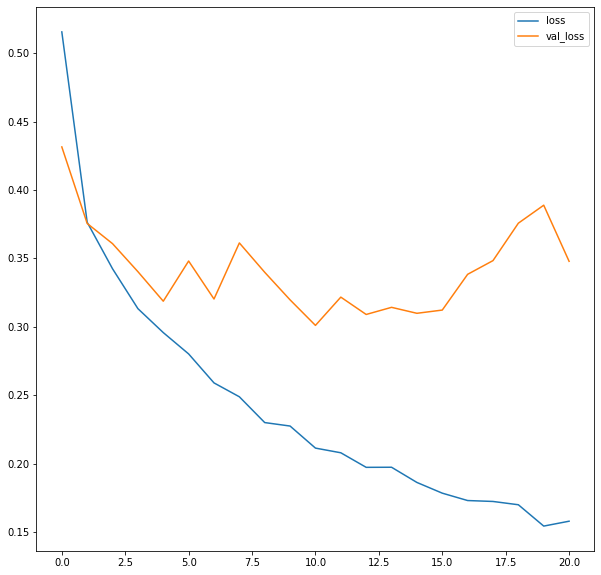

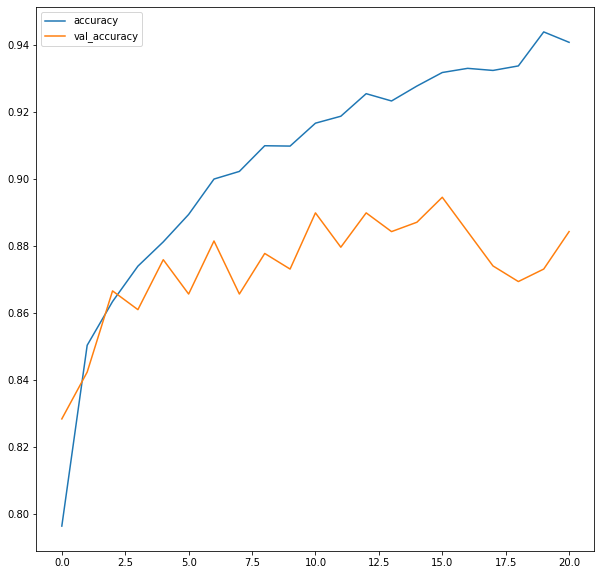

In [128]:
history_data = history.history
plt.figure(figsize=(10, 10))
plt.plot(history_data['loss'], label='loss')
plt.plot(history_data['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.figure(figsize=(10, 10))
plt.plot(history_data['accuracy'], label='accuracy')
plt.plot(history_data['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [129]:
best_model = Predictor(path_best_model)
ypred = np.argmax(best_model.predict(X_test), axis=1)
ypred -= 1
print('micro f1 = ', f1_score(test['answer'], ypred, average='micro', labels=[-1,1]))
print('macro f1 = ', f1_score(test['answer'], ypred, average='macro', labels=[-1,1]))

micro f1 =  0.5221017514595495
macro f1 =  0.46131424439141955


In [130]:
from sklearn.metrics import classification_report
print(classification_report(test['answer'], ypred))

              precision    recall  f1-score   support

          -1       0.52      0.67      0.58       784
           0       0.83      0.76      0.79      2316
           1       0.36      0.32      0.34       318

    accuracy                           0.70      3418
   macro avg       0.57      0.58      0.57      3418
weighted avg       0.71      0.70      0.70      3418



In [131]:
model.model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 28, 1, 15)         13515     
_________________________________________________________________
dropout_46 (Dropout)         (None, 28, 1, 15)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 27, 1, 30)         930       
_________________________________________________________________
flatten_24 (Flatten)         (None, 810)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 1000)              811000    
_________________________________________________________________
dense_49 (Dense)             (None, 3)                 3003      
Total params: 828,448
Trainable params: 828,448
Non-trainable params: 0
_______________________________________________